In [1]:
#pip install scikit-learn pyspark keras mlflow

In [2]:
import sklearn
import matplotlib
import mlflow
import mlflow.sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib  # To save and load the model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("joblib==",joblib.__version__)
print("pandas==",pd.__version__)
print("numpy==",np.__version__)
print("scikit-learn==",sklearn.__version__)
print("matplotlib==",matplotlib.__version__)
print("mlflow==",mlflow.__version__)

joblib== 1.4.2
pandas== 2.2.2
numpy== 1.26.2
scikit-learn== 1.4.2
matplotlib== 3.9.0
mlflow== 2.16.0


In [3]:
# Set up MLflow experiment (optional, can be named to organize runs)
mlflow.set_experiment("Isolation Forest Anomaly Detection")

2024/09/02 22:07:27 INFO mlflow.tracking.fluent: Experiment with name 'Isolation Forest Anomaly Detection' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/fox/Desktop/Project%20Model%20to%20Production/iu-model_to_production_anomaly_iot/ml_model/mlruns/507716199052430058', creation_time=1725286047645, experiment_id='507716199052430058', last_update_time=1725286047645, lifecycle_stage='active', name='Isolation Forest Anomaly Detection', tags={}>

In [4]:
# Load the dataset
df = pd.read_csv("spark_stream_data.csv")

# Prepare the data (exclude non-numerical columns if any)
numeric_df = df[['humidity', 'noise_level', 'temperature']]

# Step 1: Start MLflow run
mlflow.start_run(run_name="Isolation Forest Run")

# Step 2: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df.values)

# Log the scaler as an artifact
joblib.dump(scaler, "scaler.joblib")
mlflow.log_artifact("scaler.joblib")
scaled_data

array([[-0.43844515, -0.46457881, -0.1369981 ],
       [ 0.08731273,  2.00299292, -0.4325583 ],
       [ 0.03548809,  0.16252404, -0.91164136],
       ...,
       [ 0.02930793,  1.46216579,  0.25650172],
       [ 0.086217  ,  0.2461679 ,  0.14816848],
       [-0.2920607 ,  0.86179894, -1.16634977]])

In [5]:
# Step 3: Train the Isolation Forest model
iso_forest = IsolationForest(n_estimators=1000, contamination=0.00125, random_state=42)
iso_forest.fit(scaled_data)

# Log model parameters
mlflow.log_param("n_estimators", 1000)
mlflow.log_param("contamination", 0.00125)
mlflow.log_param("random_state", 42)

# Step 4: Save and log the trained model
joblib.dump(iso_forest, "isolation_forest_model.joblib")
mlflow.sklearn.log_model(iso_forest, "isolation_forest_model")

2024/09/02 22:07:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [6]:
# Step 5: Evaluate the model (logging metrics)
predictions = iso_forest.predict(scaled_data)
df['label'] = np.where(predictions == -1, 'Outlier', 'Normal')
num_normal = (df['label'] == 'Normal').sum()
num_outlier = (df['label'] == 'Outlier').sum()

# Log metrics
mlflow.log_metric("normal_datapoints", num_normal)
mlflow.log_metric("outlier_datapoints", num_outlier)

# Log the result summary as a text artifact
with open("result_summary.txt", "w") as f:
    f.write(f"Normal Datapoints ({round(num_normal / len(df) * 100, 2)}%): {num_normal} - Outliers ({round(num_outlier / len(df) * 100, 2)}%): {num_outlier}")
mlflow.log_artifact("result_summary.txt")

print(f"Normal Datapoints ({round(num_normal / len(df) * 100, 2)}%): {num_normal} - Outliers ({round(num_outlier / len(df) * 100, 2)}%): {num_outlier}")

Normal Datapoints (99.87%): 83779 - Outliers (0.13%): 105


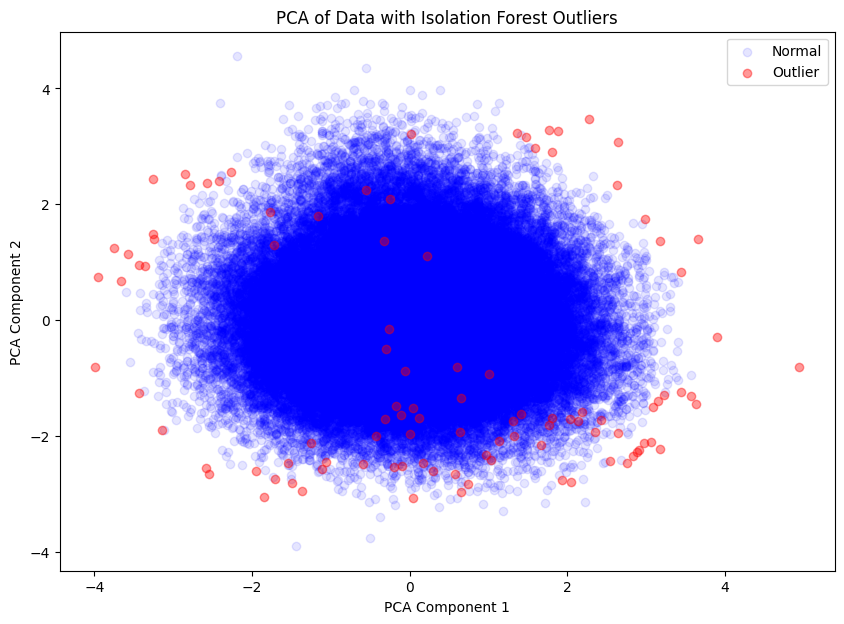

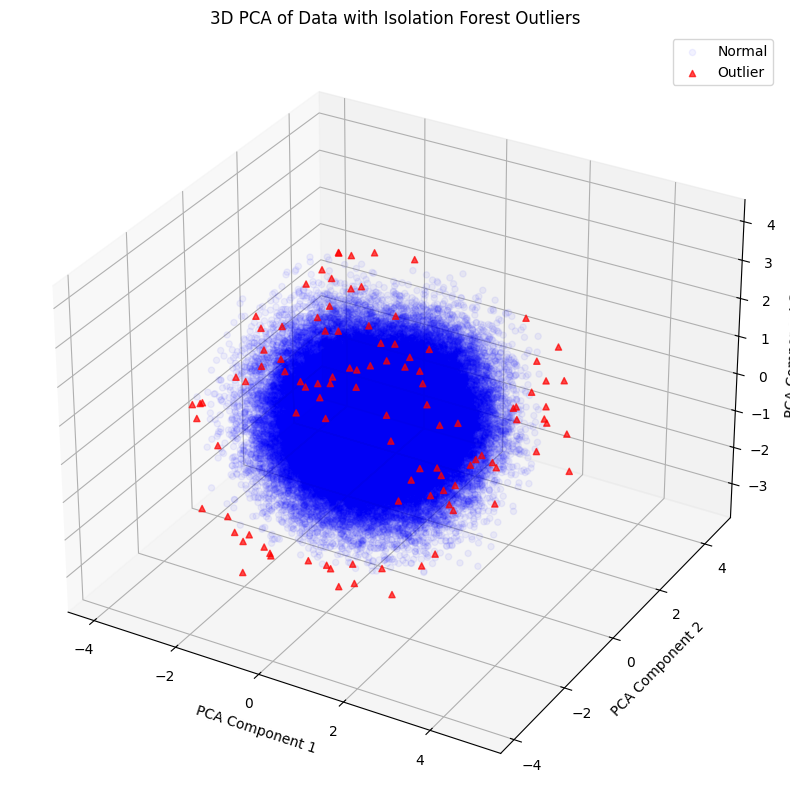

In [7]:
# Step 6: Perform PCA to reduce to 3D
pca = PCA(n_components=3)
pca_data = pca.fit_transform(scaled_data)

# Log PCA components as a parameter
mlflow.log_param("pca_components", 3)

# Add PCA components to DataFrame for plotting
df['PCA1'] = pca_data[:, 0]
df['PCA2'] = pca_data[:, 1]
df['PCA3'] = pca_data[:, 2]

# Plotting the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(df[df['label'] == 'Normal']['PCA1'], df[df['label'] == 'Normal']['PCA2'], label='Normal', alpha=0.1, c='blue')
plt.scatter(df[df['label'] == 'Outlier']['PCA1'], df[df['label'] == 'Outlier']['PCA2'], label='Outlier', alpha=0.4, c='red')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Data with Isolation Forest Outliers')
plt.legend()

# Save plot and log as artifact
plt.savefig("pca_plot.png")
mlflow.log_artifact("pca_plot.png")
plt.show()

# 3D Plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[df['label'] == 'Normal']['PCA1'], 
           df[df['label'] == 'Normal']['PCA2'], 
           df[df['label'] == 'Normal']['PCA3'], 
           label='Normal', alpha=0.05, c='blue', marker='o')

ax.scatter(df[df['label'] == 'Outlier']['PCA1'], 
           df[df['label'] == 'Outlier']['PCA2'], 
           df[df['label'] == 'Outlier']['PCA3'], 
           label='Outlier', alpha=0.7, c='red', marker='^')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA of Data with Isolation Forest Outliers')
ax.legend()

# Save 3D plot and log as artifact
plt.savefig("3d_pca_plot.png")
mlflow.log_artifact("3d_pca_plot.png")
plt.show()

In [8]:
# Step 7: End the MLflow run
mlflow.end_run()

In [24]:
# import mlflow.pyfunc
# import pandas as pd

# # Load the model from MLflow
# model_uri = 'runs:/be37c6b65f08460ab4ac5b0055a2368f/isolation_forest_model'
# loaded_model = mlflow.pyfunc.load_model(model_uri)

# # Load the scaler artifact from the MLflow run
# scaler_path = mlflow.artifacts.download_artifacts(
#     artifact_path="scaler.joblib",
#     run_id='be37c6b65f08460ab4ac5b0055a2368f'
# )

# # Load the scaler using joblib
# scaler = joblib.load(scaler_path)

# # Check mean and variance of the scaler used during training
# print(scaler.mean_)
# print(scaler.scale_)

# # Prepare the DataFrame with test data
# df = pd.DataFrame(data)

# # Prepare the features DataFrame
# features_df = df[['humidity', 'noise_level', 'temperature']]

# # Scale the features
# scaled_features = scaler.transform(features_df)


# # Predict using the loaded model
# predictions = loaded_model.predict(scaled_features)

# # Add predictions to the original DataFrame
# df['predicted_is_outlier'] = predictions == -1

# # Display the DataFrame with predictions
# print(df)
